# Report result on participants' trust and willingness to use AI

In [12]:
from base_code import *
from scipy.stats import friedmanchisquare, wilcoxon
from statannot import add_stat_annotation

valid_data = pd.read_csv('../neurosurgeon35_data/neurosurgeon35.csv', index_col='Respondent ID')
dr_wise_acc = pd.read_csv('../computational_data/dr_wise_acc.csv')

# 1. Convert the data into long table format

In [20]:
label = ["Trust-Initial", "Trust-After viewing \nperformance metrics", "Trust-After viewing \npredictions explanations"]
assist_label = ["Use-Initial", "Use-After viewing \nperformance metrics", "Use-After viewing \npredictions explanations"]
label = ["Trust1", "Trust2", "Trust3"]
assist_label = ["Use1", "Use2", "Use3"]

trust = valid_data.filter(regex='trust level').astype(float)
trust = trust.rename(columns = {c: label[i] for i,c in enumerate(trust.columns)})
trust = trust.add(5)
trust.reset_index(level=0, inplace=True)
trust = trust.set_index('Respondent ID')
# trust['label'] = 'Trust'
assist = valid_data.filter(regex = 'routine clinical practices').astype(float)
assist = assist.rename(columns = {c: assist_label[i] for i,c in enumerate(assist.columns)})
assist.reset_index(level=0, inplace=True)
assist = assist.set_index('Respondent ID')
trust_raw = trust.copy()
assist_raw = assist.copy()
trust['Position'] = trust.index.map(valid_data['Are you a'].to_dict())
assist['Position'] = trust.index.map(valid_data['Are you a'].to_dict())

trust_all = pd.concat([assist.dropna(), trust.dropna()], axis = 1, join='inner')
trust_all.reset_index(level=0, inplace=True)

# convert to long table
trust_long = pd.wide_to_long(trust_all,stubnames = ["Trust", "Use"],  i = 'Respondent ID', j = 'Event')
trust_long.reset_index(level= ['Respondent ID', 'Event'], inplace=True)

trust_longer = trust_long.melt(id_vars=["Respondent ID", "Event"], value_vars = ["Trust", "Use"])
trust_longer = trust_longer.rename(columns = {"value": "Rating", 'variable': 'Variable'})
trust_longer['Position'] = trust_longer['Respondent ID'].map(valid_data['Are you a'].to_dict())

# 2. Statistical test

In [4]:
# Trust: test assumptions for ANOVA
print(rp.summary_cont(trust['Trust1']))
print(rp.summary_cont(trust['Trust2']))
print(rp.summary_cont(trust['Trust3']))


# check ANOVA assumption 1: Univariate normality
print(pg.normality(trust['Trust1'], method = 'shapiro')    )                                
print(pg.normality(trust['Trust2'], method = 'shapiro')   )
print(pg.normality(trust['Trust3'], method = 'shapiro')  )

# check Anova assuption 2: sphericity
# https://pingouin-stats.org/generated/pingouin.sphericity.html
trust_melt = pd.melt(trust.reset_index(), id_vars='Respondent ID', value_vars=trust.columns)

print(pg.sphericity(data=trust_melt.dropna(), dv='value', within='variable', subject='Respondent ID', method = 'mauchly'))




  Variable     N    Mean      SD      SE  95% Conf.  Interval
0   Trust1  35.0  5.5143  2.1608  0.3652      4.772    6.2565


  Variable     N    Mean      SD      SE  95% Conf.  Interval
0   Trust2  35.0  6.8286  1.7061  0.2884     6.2425    7.4147


  Variable     N    Mean      SD      SE  95% Conf.  Interval
0   Trust3  29.0  6.6207  2.6781  0.4973      5.602    7.6394
              W      pval  normal
Trust1  0.92728  0.023241   False
               W      pval  normal
Trust2  0.894703  0.002857   False
               W      pval  normal
Trust3  0.790285  0.000056   False
SpherResults(spher=False, W=0.6103225554115219, chi2=13.331727419566667, dof=2, pval=0.0012736560817791893)


In [5]:
# Willingness to use AI: test assumptions for ANOVA
print(rp.summary_cont(assist['Use1']))
print(rp.summary_cont(assist['Use2']))
print(rp.summary_cont(assist['Use3']))


# check ANOVA assumption 1: Univariate normality
print(pg.normality(assist['Use1'], method = 'shapiro')    )                                
print(pg.normality(assist['Use2'], method = 'shapiro')   )
print(pg.normality(assist['Use3'], method = 'shapiro')  )

# check Anova assuption 2: sphericity
# https://pingouin-stats.org/generated/pingouin.sphericity.html
assist_melt = pd.melt(assist.reset_index(), id_vars='Respondent ID', value_vars=assist.columns)

print(pg.sphericity(data=assist_melt.dropna(), dv='value', within='variable', subject='Respondent ID', method = 'mauchly'))




  Variable     N    Mean      SD      SE  95% Conf.  Interval
0     Use1  35.0  4.1143  2.8571  0.4829     3.1328    5.0957


  Variable     N  Mean      SD      SE  95% Conf.  Interval
0     Use2  35.0   5.2  2.2983  0.3885     4.4105    5.9895


  Variable     N    Mean      SD      SE  95% Conf.  Interval
0     Use3  29.0  4.5862  3.1568  0.5862     3.3854     5.787
             W      pval  normal
Use1  0.918898  0.013253   False
             W      pval  normal
Use2  0.964022  0.300809    True
             W      pval  normal
Use3  0.874987  0.002598   False
SpherResults(spher=False, W=0.35382929156885023, chi2=28.05139915282619, dof=2, pval=8.104310450727294e-07)


In [4]:
# descriptive statistics reporting
def acc_test_report(df, label):
    y_label = ['Bsl',"Pfm","Use"]
    for i, cd in enumerate([label+str(j) for j in range(1,4)]):
        sub_df = df[cd]
        adict = sub_df.describe().to_dict()
        print('& {} &  {:.0f} & ${:.2f}\pm{:.2f}$ & {:.2f} & {:.2f}& {:.2f}& {:.2f}& {:.2f} \\\\'.format(y_label[i], adict['count'], adict['mean'],adict['std'],
                                                               adict['min'], adict['25%'], adict['50%'], adict['75%'], adict['max']))
# all participants, trust
acc_test_report(trust.dropna(), 'Trust')

& Bsl &  29 & $5.31\pm2.04$ & 0.00 & 5.00& 5.00& 7.00& 9.00 \\
& Pfm &  29 & $6.72\pm1.67$ & 3.00 & 5.00& 7.00& 8.00& 9.00 \\
& Use &  29 & $6.62\pm2.68$ & 0.00 & 6.00& 8.00& 8.00& 9.00 \\


In [7]:
# all participants, willingness
acc_test_report(assist.dropna(), 'Use')

& Bsl &  29 & $4.10\pm2.79$ & 0.00 & 2.00& 5.00& 5.00& 10.00 \\
& Pfm &  29 & $5.07\pm2.45$ & 0.00 & 3.00& 5.00& 7.00& 10.00 \\
& Use &  29 & $4.59\pm3.16$ & 0.00 & 1.00& 5.00& 8.00& 9.00 \\


In [11]:
# Friedman test
trust_dpd = [list(trust.dropna()[col]) for col in trust]
stat_t, p_t = friedmanchisquare(*trust_dpd)
print("Trust, Friedman test: stat: {}, p: {}".format(stat_t, p_t))


assist_dpd = [list(assist.dropna()[col]) for col in assist]
stat_a, p_a = friedmanchisquare(*assist_dpd)
print("Willingness to use AI, Friedman test: stat: {}, p: {}".format(stat_a, p_a))

Trust, Friedman test: stat: 16.96703296703298, p: 0.0002068500375516274
Willingness to use AI, Friedman test: stat: 8.088888888888896, p: 0.017519434972107253


In [12]:
# Trust, post-hoc test, reporting result
w, p1 = wilcoxon(np.array(trust.dropna()['Trust1']), np.array(trust.dropna()['Trust2']))#, alternative  = 'greater')
print(w, p1*3)
w, p2 = wilcoxon(np.array(trust.dropna()['Trust1']), np.array(trust.dropna()['Trust3']))#, alternative  = 'greater')
print(w, p2*3)
w, p3 = wilcoxon(np.array(trust.dropna()['Trust2']) ,np.array(trust.dropna()['Trust3']))# alternative  = 'greater')
print(w, p3*3)

4.0 0.00041753173917002614
58.0 0.02457026771794276
96.0 2.2033085535799986


In [13]:
# Willingness to use AI, post-hoc test, reporting result
w, p1 = wilcoxon(np.array(assist.dropna()['Use1']), np.array(assist.dropna()['Use2']))#, alternative  = 'greater')
print(w, p1*3)
w, p2 = wilcoxon(np.array(assist.dropna()['Use1']), np.array(assist.dropna()['Use3']))#, alternative  = 'greater')
print(w, p2*3)
w, p3 = wilcoxon(np.array(assist.dropna()['Use2']) ,np.array(assist.dropna()['Use3']))# alternative  = 'greater')
print(w, p3*3)

29.5 0.01231106400170777
94.5 0.8878120015168015
101.0 1.2047868339318817


# 3. Visualize the results

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
1 v.s. 2: Wilcoxon test (paired samples) with Bonferroni correction, P_val=4.175e-04 stat=4.000e+00
Using zero_method  wilcox
2 v.s. 3: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.000e+00 stat=9.600e+01
Using zero_method  wilcox
1 v.s. 3: Wilcoxon test (paired samples) with Bonferroni correction, P_val=2.457e-02 stat=5.800e+01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
1 v.s. 2: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.231e-02 stat=2.950e+01
Using zero_method  wilcox
2 v.s. 3: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.000e+00 stat=1.010e+02
Using zero_method  wilcox
1 v.s. 3: Wilcox

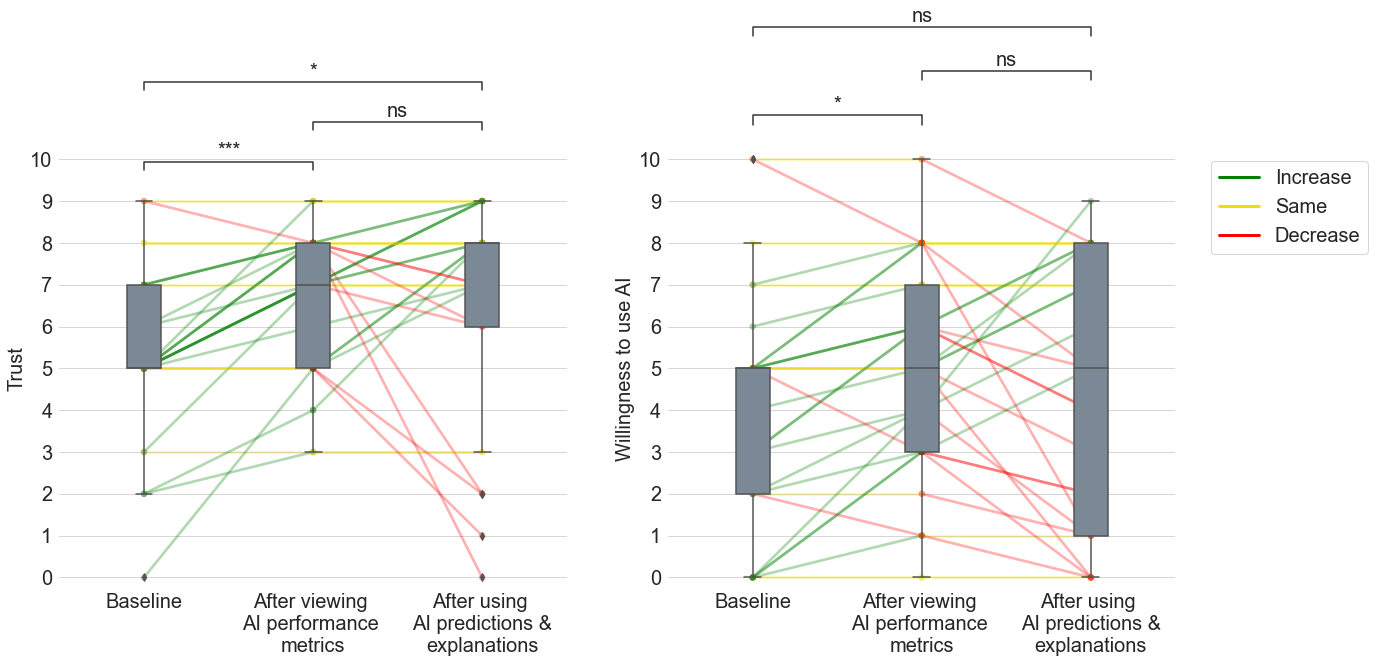

In [18]:
from matplotlib.lines import Line2D

sns.set_style('whitegrid', {'axes.linewidth': 2, 'axes.edgecolor':'white'})
plt.rcParams.update({'font.size': 20})
yellow = '#F0DE00'

f, (ax1, ax2) = plt.subplots(1, 2,  figsize= (20,8))

g1 = pg.plot_paired(ax = ax1, data = trust_longer[trust_longer['Variable']=='Trust'], within = 'Event', dv = 'Rating', subject='Respondent ID', dpi=150, pointplot_kwargs={'alpha': 0.3, 'scale': 1, 'marker': 'o'}, colors = ['green', yellow,'red','orange'], boxplot_in_front=True)

# add significance for boxplot
# Ref: https://stackoverflow.com/questions/36578458/how-does-one-insert-statistical-annotations-stars-or-p-values-into-matplotlib/37518947#37518947
add_stat_annotation(ax1, data=trust_longer[trust_longer['Variable']=='Trust'], x='Event', y= 'Rating', 
                    box_pairs=[(1, 2), (2, 3), (1, 3)],
                    test='Wilcoxon', stats_params ={'alternative':'two-sided'},text_format='star', loc='outside', verbose=2)
y_label = ['Baseline',"After viewing \nAI performance \nmetrics","After using \nAI predictions &\nexplanations"]
g1.set_yticks(range(11))
ylim = (-0.2,10.2)
g1.set_ylim(ylim)
g1.set_yticks(range(11))
g1.set_xticklabels(y_label)
g1.set_xlabel('')
g1.set_ylabel('Trust')
g1.spines['left'].set_visible(False)
g1.spines['bottom'].set_visible(False)

g2 = pg.plot_paired(ax = ax2, data = trust_longer[trust_longer['Variable']=='Use'], within = 'Event', dv = 'Rating', subject='Respondent ID', dpi=150, pointplot_kwargs={'alpha': 0.3, 'scale': 1, 'marker': 'o'}, colors = ['green', yellow,'red','orange'], boxplot_in_front=True)

# add significance for boxplot
# Ref: https://stackoverflow.com/questions/36578458/how-does-one-insert-statistical-annotations-stars-or-p-values-into-matplotlib/37518947#37518947
add_stat_annotation(ax2, data=trust_longer[trust_longer['Variable']=='Use'], x='Event', y= 'Rating', 
                    box_pairs=[(1, 2), (2, 3), (1, 3)],
                    test='Wilcoxon', stats_params ={'alternative':'two-sided'}, text_format='star', loc='outside', verbose=2)
g2.set_yticks(range(11))
g2.set_ylim(ylim)
g2.set_xticklabels(y_label)
g2.set_xlabel('')
g2.set_ylabel('Willingness to use AI')
# g2.title.set_text("Willing to Use AI")
g2.spines['left'].set_visible(False)
g2.spines['bottom'].set_visible(False)

lw = 3
custom_lines = [Line2D([0], [0], color="green", lw=lw),
                Line2D([0], [0], color= yellow, lw=lw),
                Line2D([0], [0], color='red', lw=lw)]

g2.legend(custom_lines, ['Increase', 'Same', 'Decrease'], bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.savefig("../reporting/trust_use_ai_change.pdf", transparent=True, bbox_inches = 'tight')


# 4. Correlation between trust and willingness to use AI 

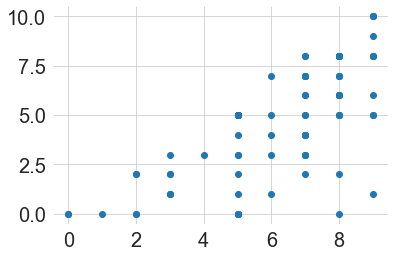

In [20]:
# correlation between trust and willing 
plt.scatter(trust_long['Trust'], trust_long['Use'])

In [21]:
# normality assumption test for pearson r correlation
print(pg.normality(trust_long['Trust']))                                    
print(pg.normality(trust_long['Use']))    


              W      pval  normal
Trust  0.901395  0.000006   False
            W      pval  normal
Use  0.947014  0.001375   False


In [22]:
# since the normality assumption for pearson r failed, and both are ordinal measure, we report spearman correlation
from scipy.stats import spearmanr
spearmanr(trust_long['Trust'], trust_long['Use'])

SpearmanrResult(correlation=0.7046157150614029, pvalue=2.622190688367616e-14)

# 5. Fine-grained results for attending physicians, and resident + fellow physicians

In [8]:
trust_dropna = trust.dropna()
assist_dropna = assist.dropna()
# attending physician report
acc_test_report(trust_dropna[trust_dropna['Position']=='Attending Physician'], 'Trust')
acc_test_report(assist_dropna[assist_dropna['Position']=='Attending Physician'], 'Use')

& Bsl &  10 & $5.20\pm2.35$ & 2.00 & 3.50& 5.00& 5.75& 9.00 \\
& Pfm &  10 & $6.80\pm2.15$ & 3.00 & 7.00& 7.00& 8.00& 9.00 \\
& Use &  10 & $6.50\pm2.84$ & 2.00 & 3.75& 7.50& 9.00& 9.00 \\
& Bsl &  10 & $4.00\pm3.40$ & 0.00 & 2.00& 3.00& 4.50& 10.00 \\
& Pfm &  10 & $4.90\pm3.28$ & 0.00 & 2.50& 5.00& 7.50& 10.00 \\
& Use &  10 & $3.80\pm3.39$ & 0.00 & 1.00& 2.50& 7.50& 8.00 \\


In [9]:
# resident & fellow report
acc_test_report(trust_dropna[trust_dropna['Position']!='Attending Physician'], 'Trust')
acc_test_report(assist_dropna[assist_dropna['Position']!='Attending Physician'], 'Use')

& Bsl &  19 & $5.37\pm1.92$ & 0.00 & 5.00& 5.00& 7.00& 8.00 \\
& Pfm &  19 & $6.68\pm1.42$ & 4.00 & 5.00& 7.00& 8.00& 8.00 \\
& Use &  19 & $6.68\pm2.67$ & 0.00 & 7.00& 8.00& 8.00& 9.00 \\
& Bsl &  19 & $4.16\pm2.52$ & 0.00 & 3.00& 5.00& 5.00& 8.00 \\
& Pfm &  19 & $5.16\pm1.98$ & 1.00 & 3.50& 5.00& 6.50& 8.00 \\
& Use &  19 & $5.00\pm3.04$ & 0.00 & 2.50& 5.00& 7.50& 9.00 \\


In [14]:
# Friedman test, attending
attend_trust = trust_dropna[trust_dropna['Position']=='Attending Physician']
attend_assist = assist_dropna[assist_dropna['Position']=='Attending Physician']
trust_dpd = [list(attend_trust[col]) for col in trust_raw]
stat_t, p_t = friedmanchisquare(*trust_dpd)
print("Trust Friedman test: stat: {}, p: {}".format(stat_t, p_t))


assist_dpd = [list(attend_assist[col]) for col in assist_raw]
stat_a, p_a = friedmanchisquare(*assist_dpd)
print("Assist Friedman test: stat: {}, p: {}".format(stat_a, p_a))

Trust Friedman test: stat: 5.555555555555555, p: 0.06217652402211632
Assist Friedman test: stat: 1.750000000000007, p: 0.4168620196785071


In [15]:
# Friedman test, resident
attend_trust = trust_dropna[trust_dropna['Position']!='Attending Physician']
attend_assist = assist_dropna[assist_dropna['Position']!='Attending Physician']
trust_dpd = [list(attend_trust[col]) for col in trust_raw]
stat_t, p_t = friedmanchisquare(*trust_dpd)
print("Trust Friedman test: stat: {}, p: {}".format(stat_t, p_t))


assist_dpd = [list(attend_assist[col]) for col in assist_raw]
stat_a, p_a = friedmanchisquare(*assist_dpd)
print("Assist Friedman test: stat: {}, p: {}".format(stat_a, p_a))

Trust Friedman test: stat: 11.468749999999972, p: 0.0032329023009884474
Assist Friedman test: stat: 7.862068965517241, p: 0.019623362019752715


In [16]:
# post-hoc test, trust, resident
w, p1 = wilcoxon(np.array(attend_trust.dropna()['Trust1']), np.array(attend_trust.dropna()['Trust2']))#, alternative  = 'greater')
print(w, p1*3)
w, p2 = wilcoxon(np.array(attend_trust.dropna()['Trust1']), np.array(attend_trust.dropna()['Trust3']))#, alternative  = 'greater')
print(w, p2*3)
w, p3 = wilcoxon(np.array(attend_trust.dropna()['Trust2']) ,np.array(attend_trust.dropna()['Trust3']))# alternative  = 'greater')
print(w, p3*3)

0.0 0.00587350738297599
35.5 0.08579819829866069
53.0 2.0665663553608575


/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [17]:
# post-hoc test, assist, resident
w, p1 = wilcoxon(np.array(attend_assist.dropna()['Use1']), np.array(attend_assist.dropna()['Use2']))#, alternative  = 'greater')
print(w, p1*3)
w, p2 = wilcoxon(np.array(attend_assist.dropna()['Use1']), np.array(attend_assist.dropna()['Use3']))#, alternative  = 'greater')
print(w, p2*3)
w, p3 = wilcoxon(np.array(attend_assist.dropna()['Use2']) ,np.array(attend_assist.dropna()['Use3']))# alternative  = 'greater')
print(w, p3*3)

9.0 0.026206366711850206
27.0 0.5803414599329905
56.5 2.52251478396448


# 6. Visualize attending and resident+fellow trust and willingness to use AI

In [21]:
trust_res = trust_longer[trust_longer['Position']!='Attending Physician']
trust_attend = trust_longer[trust_longer['Position']=='Attending Physician']
trust_attend.shape, trust_res.shape, trust_longer.shape

((60, 5), (114, 5), (174, 5))

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  pratt
1 v.s. 2: Wilcoxon test (paired samples) with Bonferroni correction, P_val=7.033e-02 stat=4.000e+00
Using zero_method  pratt
2 v.s. 3: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.000e+00 stat=1.700e+01
Using zero_method  pratt
1 v.s. 3: Wilcoxon test (paired samples) with Bonferroni correction, P_val=2.649e-01 stat=6.500e+00


/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  pratt
1 v.s. 2: Wilcoxon test (paired samples) with Bonferroni correction, P_val=4.779e-01 stat=1.100e+01
Using zero_method  pratt
2 v.s. 3: Wilcoxon test (paired samples) with Bonferroni correction, P_val=6.878e-01 stat=1.300e+01
Using zero_method  pratt
1 v.s. 3: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.000e+00 stat=2.700e+01


/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


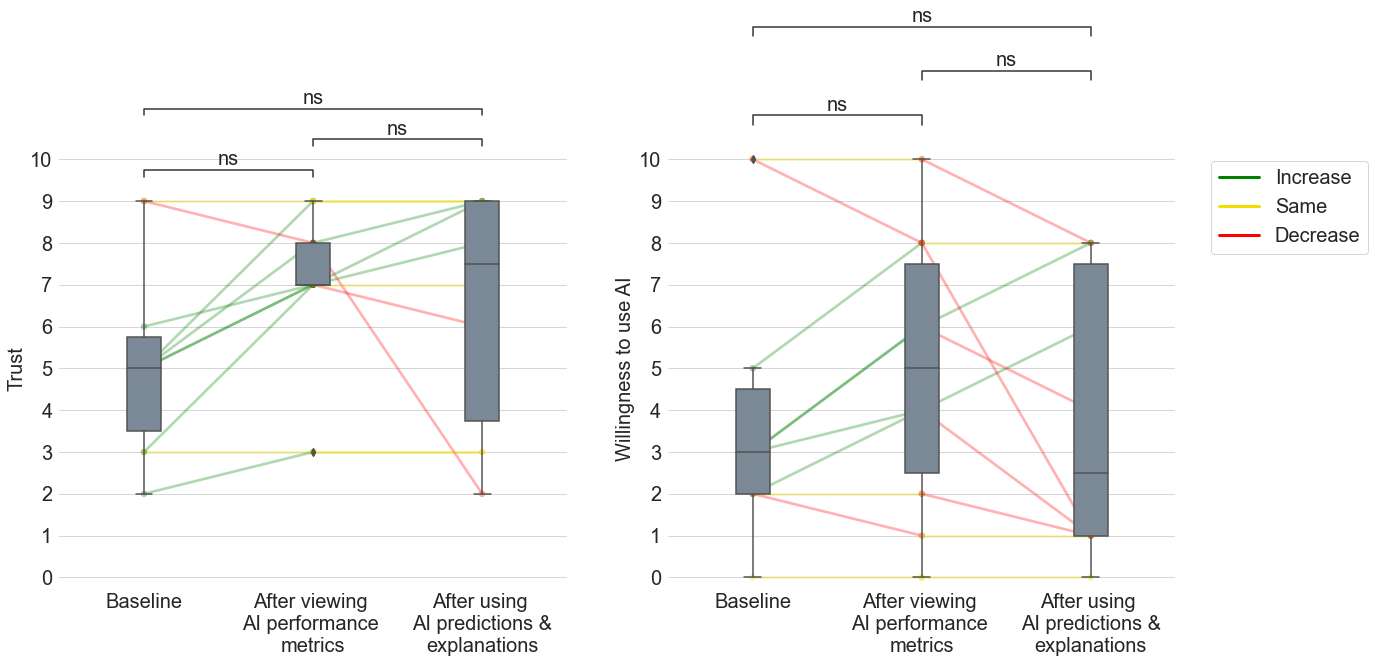

In [23]:
from matplotlib.lines import Line2D

sns.set_style('whitegrid', {'axes.linewidth': 2, 'axes.edgecolor':'white'})
plt.rcParams.update({'font.size': 20})
yellow = '#F0DE00'

f, (ax1, ax2) = plt.subplots(1, 2,  figsize= (20,8))
trust_longer = trust_attend
g1 = pg.plot_paired(ax = ax1, data = trust_longer[trust_longer['Variable']=='Trust'], within = 'Event', dv = 'Rating', subject='Respondent ID', dpi=150, pointplot_kwargs={'alpha': 0.3, 'scale': 1, 'marker': 'o'}, colors = ['green', yellow,'red'],boxplot_in_front=True)

# add significance for boxplot
# Ref: https://stackoverflow.com/questions/36578458/how-does-one-insert-statistical-annotations-stars-or-p-values-into-matplotlib/37518947#37518947
add_stat_annotation(ax1, data=trust_longer[trust_longer['Variable']=='Trust'], x='Event', y= 'Rating', 
                    box_pairs=[(1, 2), (2, 3), (1, 3)],
                    test='Wilcoxon', stats_params ={'alternative':'two-sided'},text_format='star', loc='outside', verbose=2)
y_label = ['Baseline',"After viewing \nAI performance \nmetrics","After using \nAI predictions &\nexplanations"]
g1.set_yticks(range(11))
ylim = (-0.2,10.2)
g1.set_ylim(ylim)
g1.set_yticks(range(11))
g1.set_xticklabels(y_label)
g1.set_xlabel('')
g1.set_ylabel('Trust')
# g1.title.set_text("Trust")
g1.spines['left'].set_visible(False)
g1.spines['bottom'].set_visible(False)
# g1.set_ylabel("Trust")
# ax.set_title("Accuracy w/o and w/ AI/XAI assistance")

g2 = pg.plot_paired(ax = ax2, data = trust_longer[trust_longer['Variable']=='Use'], within = 'Event', dv = 'Rating', subject='Respondent ID', dpi=150, pointplot_kwargs={'alpha': 0.3, 'scale': 1, 'marker': 'o'}, colors = ['green', yellow,'red'], boxplot_in_front=True)

# add significance for boxplot
# Ref: https://stackoverflow.com/questions/36578458/how-does-one-insert-statistical-annotations-stars-or-p-values-into-matplotlib/37518947#37518947
add_stat_annotation(ax2, data=trust_longer[trust_longer['Variable']=='Use'], x='Event', y= 'Rating', 
                    box_pairs=[(1, 2), (2, 3), (1, 3)],
                    test='Wilcoxon', stats_params ={'alternative':'two-sided'}, text_format='star', loc='outside', verbose=2)
g2.set_yticks(range(11))
g2.set_ylim(ylim)
g2.set_xticklabels(y_label)
g2.set_xlabel('')
g2.set_ylabel('Willingness to use AI')
g2.spines['left'].set_visible(False)
g2.spines['bottom'].set_visible(False)

lw = 3

custom_lines = [Line2D([0], [0], color="green",  lw=lw),
                Line2D([0], [0], color=yellow, lw=lw),
                Line2D([0], [0], color='red', lw=lw)]
g2.legend(custom_lines, ['Increase', 'Same', 'Decrease'], bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.savefig("../reporting/trust_use_ai_change_attend.pdf", transparent=True, bbox_inches = 'tight')


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  pratt
1 v.s. 2: Wilcoxon test (paired samples) with Bonferroni correction, P_val=2.277e-03 stat=0.000e+00
Using zero_method  pratt
2 v.s. 3: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.000e+00 stat=7.700e+01
Using zero_method  pratt
1 v.s. 3: Wilcoxon test (paired samples) with Bonferroni correction, P_val=7.851e-02 stat=3.950e+01


/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  pratt
1 v.s. 2: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.206e-02 stat=1.500e+01
Using zero_method  pratt
2 v.s. 3: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.000e+00 stat=8.050e+01
Using zero_method  pratt
1 v.s. 3: Wilcoxon test (paired samples) with Bonferroni correction, P_val=5.061e-01 stat=5.100e+01


/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


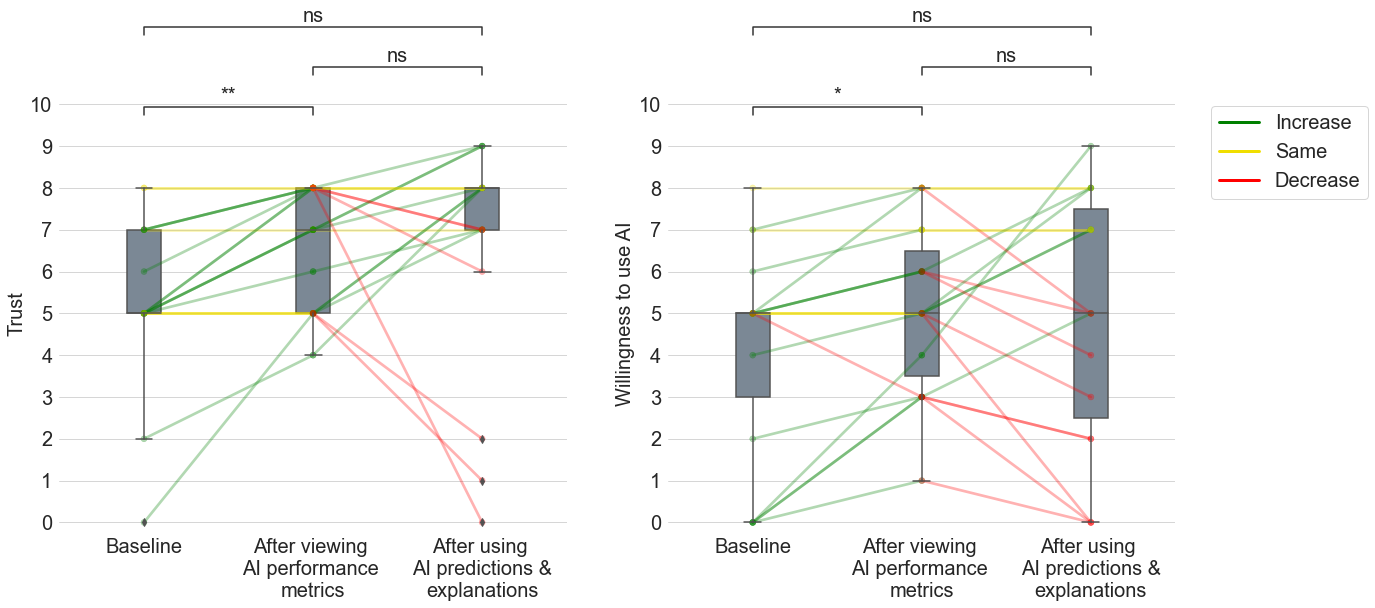

In [33]:
from matplotlib.lines import Line2D

sns.set_style('whitegrid', {'axes.linewidth': 2, 'axes.edgecolor':'white'})
plt.rcParams.update({'font.size': 20})
yellow = '#F0DE00'

f, (ax1, ax2) = plt.subplots(1, 2,  figsize= (20,8))
trust_longer = trust_res
g1 = pg.plot_paired(ax = ax1, data = trust_longer[trust_longer['Variable']=='Trust'], within = 'Event', dv = 'Rating', subject='Respondent ID', dpi=150, pointplot_kwargs={'alpha': 0.3, 'scale': 1, 'marker': 'o'}, colors = ['green', yellow,'red'],boxplot_in_front=False)

# add significance for boxplot
# Ref: https://stackoverflow.com/questions/36578458/how-does-one-insert-statistical-annotations-stars-or-p-values-into-matplotlib/37518947#37518947
add_stat_annotation(ax1, data=trust_longer[trust_longer['Variable']=='Trust'], x='Event', y= 'Rating', 
                    box_pairs=[(1, 2), (2, 3), (1, 3)],
                    test='Wilcoxon', stats_params ={'alternative':'two-sided'},text_format='star', loc='outside', verbose=2)
y_label = ['Baseline',"After viewing \nAI performance \nmetrics","After using \nAI predictions &\nexplanations"]
g1.set_yticks(range(11))
ylim = (-0.2,10.2)
g1.set_ylim(ylim)
g1.set_yticks(range(11))
g1.set_xticklabels(y_label)
g1.set_xlabel('')
g1.set_ylabel('Trust')
g1.spines['left'].set_visible(False)
g1.spines['bottom'].set_visible(False)

g2 = pg.plot_paired(ax = ax2, data = trust_longer[trust_longer['Variable']=='Use'], within = 'Event', dv = 'Rating', subject='Respondent ID', dpi=150, pointplot_kwargs={'alpha': 0.3, 'scale': 1, 'marker': 'o'}, colors = ['green', yellow,'red'], boxplot_in_front=False)

# add significance for boxplot
# Ref: https://stackoverflow.com/questions/36578458/how-does-one-insert-statistical-annotations-stars-or-p-values-into-matplotlib/37518947#37518947
add_stat_annotation(ax2, data=trust_longer[trust_longer['Variable']=='Use'], x='Event', y= 'Rating', 
                    box_pairs=[(1, 2), (2, 3), (1, 3)],
                    test='Wilcoxon', stats_params ={'alternative':'two-sided'}, text_format='star', loc='outside', verbose=2)
g2.set_yticks(range(11))
g2.set_ylim(ylim)
g2.set_xticklabels(y_label)
g2.set_xlabel('')
g2.set_ylabel('Willingness to use AI')
g2.spines['left'].set_visible(False)
g2.spines['bottom'].set_visible(False)
lw = 3

custom_lines = [Line2D([0], [0], color="green",  lw=lw),
                Line2D([0], [0], color=yellow, lw=lw),
                Line2D([0], [0], color='red', lw=lw)]
g2.legend(custom_lines, ['Increase', 'Same', 'Decrease'], bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.savefig("../reporting/trust_use_ai_change_resident.pdf", transparent=True, bbox_inches = 'tight')